## Импорты

In [3]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [4]:
from math import pi, e, cos
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import *
from sklearn.linear_model import LinearRegression
import optuna

## Алгоритм kNN

In [13]:
class kNN:
    X = None
    Y = None
    prior_weights = None
    lowess_weights = None

    def __init__(self, n_neighbors, kernel="uniform", metric="minkowski", p=1, h=None):
        self.n_neighbors = n_neighbors
        self.kernel = kernel
        self.metric = metric
        self.p = p
        self.h = h

    def fit(self, X, Y, prior_weights=None):
        if len(X) != len(Y):
            raise ValueError('''X and Y must has the same length''')
        if prior_weights is not None and len(X) != len(prior_weights):
            raise ValueError('''X and prior_weights must has the same length''')
        self.X = X
        self.Y = Y
        self.prior_weights = prior_weights

    def predict(self, X):
        if self.X is None or self.Y is None:
            raise ValueError('''X or Y cannot be None''')

        prediction = []
        selected_kernel = self.__kernel()
        selected_metric = self.__metric()

        for x in X:
            window_size = self.__window_size(x, selected_metric)
            max_arg = 0
            y_predicted = None
            for y in set(self.Y):
                sum_w = 0
                for i in range(len(self.X)):
                    if self.prior_weights is None:
                        weight = selected_kernel(selected_metric(x, self.X[i]) / window_size)
                    else:
                        weight = self.prior_weights[i] * selected_kernel(selected_metric(x, self.X[i]) / window_size)
                    sum_w += int(self.Y[i] == y) * weight
                if sum_w > max_arg:
                    max_arg = sum_w
                    y_predicted = y
            if y_predicted is None:
                y_predicted = np.random.choice(list(set(self.Y)))
            prediction.append(y_predicted)

        return prediction

    def __window_size(self, x, metric):
        if self.h is not None:
            return self.h

        dist = []
        for neighbor in self.X:
            dist.append(metric(x, neighbor))

        dist.sort()

        window_size = dist[self.n_neighbors] + 10 ** (-8)
        return window_size

    def __kernel(self):
        if self.kernel == "uniform":
            return lambda x: self.__uniform_kernel(x)
        elif self.kernel == "triangular":
            return lambda x: self.__triangular_kernel(x)
        elif self.kernel == "gaussian":
            return lambda x: self.__gaussian_kernel(x)
        elif self.kernel == "epanechnikov":
            return lambda x: self.__epanechnikov_kernel(x)
        elif self.kernel == "cosine":
            return lambda x: self.__cosine_kernel(x)
        else:
            raise ValueError('''The introduced kernel does not exist or is not implemented in this class.
            Select one of the following kernels: uniform, triangular, gaussian, epanechnikov, cosine''')

    def __metric(self):
        if self.metric == "minkowski":
            if self.p is not None:
                return lambda x, y: self.__minkowski_metric(x, y, self.p)
            raise ValueError('You didn`t enter parameter \'p\'')
        elif self.metric == "manhattan":
            return lambda x, y: self.__minkowski_metric(x, y, 1)
        elif self.metric == "euclidean":
            return lambda x, y: self.__minkowski_metric(x, y, 2)
        elif self.metric == "chebyshev":
            return lambda x, y: self.__chebyshev_metric(x, y)
        elif self.metric == "cosine":
            return lambda x, y: self.__cosine_metric(x, y)
        else:
            raise ValueError('''The introduced metric does not exist or is not implemented in this class.
            Select one of the following metrics: minkowski, manhattan, euclidean, chebyshev, cosine''')

    @staticmethod
    def __uniform_kernel(x):
        if -1 < x < 1:
            return 0.5
        else:
            return 0

    @staticmethod
    def __triangular_kernel(x):
        if -1 < x < 1:
            return 1 - abs(x)
        else:
            return 0

    @staticmethod
    def __gaussian_kernel(x):
        return (1 / ((2 * pi) ** 0.5)) * e ** (-0.5 * (x ** 2))

    @staticmethod
    def __epanechnikov_kernel(x):
        if -1 < x < 1:
            return 0.75 * (1 - x ** 2)
        else:
            return 0

    @staticmethod
    def __cosine_kernel(x):
        return (pi / 4) * cos(pi * x / 2)

    @staticmethod
    def __minkowski_metric(x, y, p):
        # if len(x) != len(y):
        #     raise ValueError('''X and Y has different size''')
        sum_diff = 0
        for i in range(len(x)):
            sum_diff += abs(x[i] - y[i]) ** p
        return sum_diff ** (1 / p)

    @staticmethod
    def __chebyshev_metric(x, y):
        if len(x) != len(y):
            raise ValueError('''X and Y has different size''')
        max_diff = 0
        for i in range(len(x)):
            max_diff = max(abs(x[i] - y[i]), max_diff)
        return max_diff

    @staticmethod
    def __cosine_metric(x, y):
        if len(x) != len(y):
            raise ValueError('''X and Y has different size''')
        numerator = 0
        for i in range(len(x)):
            numerator += x[i] * y[i]
            x_2 = sum([i ** 2 for i in x])
            y_2 = sum([i ** 2 for i in y])
        return 1 - numerator / ((x_2 ** 0.5) * (y_2 ** 0.5))

    def lowess_predict(self, X):
        self.__lowess()

        if self.X is None or self.Y is None:
            raise ValueError('''X or Y cannot be None''')

        prediction = []
        selected_kernel = self.__kernel()
        selected_metric = self.__metric()

        for x in X:
            window_size = self.__window_size(x, selected_metric)
            max_arg = 0
            y_predicted = None
            for y in set(self.Y):
                sum_w = 0
                for i in range(len(self.X)):
                    if self.prior_weights is None:
                        weight = selected_kernel(selected_metric(x, self.X[i]) / window_size)
                    else:
                        weight = self.prior_weights[i] * selected_kernel(selected_metric(x, self.X[i]) / window_size)
                    sum_w += int(self.Y[i] == y) * weight * self.lowess_weights[i]
                if sum_w > max_arg:
                    max_arg = sum_w
                    y_predicted = y
            if y_predicted is None:
                y_predicted = np.random.choice(list(set(self.Y)))
            prediction.append(y_predicted)

        return prediction

    def soft_predict(self, X):
        if self.X is None or self.Y is None:
            raise ValueError('''X or Y cannot be None''')

        prediction = []
        selected_kernel = self.__kernel()
        selected_metric = self.__metric()

        for x in X:
            window_size = self.__window_size(x, selected_metric)
            y_predicted = []
            for y in set(self.Y):
                sum_w = 0
                for i in range(len(self.X)):
                    if self.prior_weights is None:
                        weight = selected_kernel(selected_metric(x, self.X[i]) / window_size)
                    else:
                        weight = self.prior_weights[i] * selected_kernel(selected_metric(x, self.X[i]) / window_size)
                    sum_w += int(self.Y[i] == y) * weight

                y_predicted.append(sum_w)

                sum_y = sum(y_predicted)
                if sum_y != 0:
                    y_predicted = [i / sum_y for i in y_predicted]

                if len(y_predicted) == 0:
                    y_random = np.random.choice(list(set(self.Y)))
                    y_predicted = [0] * len(self.Y)
                    y_predicted[y_random] = 1

            prediction.append(y_predicted)

        return prediction

    def __lowess(self):

        selected_kernel = self.__kernel()

        selected_metric = self.__metric()

        self.lowess_weights = []

        for i in tqdm(range(len(self.X))):
            X_new = np.delete(self.X, i, axis=0)
            Y_new = np.delete(self.Y, i, axis=0)

            knn = kNN(n_neighbors=self.n_neighbors, kernel=self.kernel, metric=self.metric, p=self.p, h=self.h)
            knn.fit(X=X_new, Y=Y_new)
            y_predicted = knn.soft_predict(np.array([self.X[i]]))[0]

            # регрессия
            Y_vec = []
            for j in range(len(self.Y)):
                Y_vec.append([0] * len(set(self.Y)))
                Y_vec[j][self.Y[j]] = 1

            Y_vec = np.array(Y_vec)

            # print(np.linalg.norm(Y_regr - y_predicted))
            w = selected_kernel(np.linalg.norm(Y_vec - y_predicted))
            self.lowess_weights.append(w)

## Обработка данных перед алгоритмом

In [5]:
df = pd.read_csv("processed_data.tsv", sep='\t')

X = df.drop(columns=['Система размораживания холодильной камеры', 'Название'], axis=1)
Y = df['Система размораживания холодильной камеры']

y_values = df['Система размораживания холодильной камеры'].drop_duplicates().tolist()

y_map = {i: y_values.index(i) for i in y_values}

for i in range(len(df)):
    Y.at[i] = y_map[Y[i]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21, stratify=df['Система размораживания холодильной камеры'])
X_train, X_check, Y_train, Y_check = train_test_split(X_train, Y_train, test_size=0.2, random_state=21)

Y_train = Y_train.astype(int)
Y_check = Y_check.astype(int)
Y_test = Y_test.astype(int)

X.head()

,Цена,Количество камер,Количество дверей,Инверторный компрессор,Размеры (Ширина),Размеры (Высота),Размеры (Глубина),Тип_Винный шкаф,Тип_Холодильная витрина,Тип_Холодильник,...,Расположение морозильной камеры_слева,Расположение морозильной камеры_снизу,Класс энергопотребления_A,Класс энергопотребления_A+,Класс энергопотребления_A++,Класс энергопотребления_B,Класс энергопотребления_C,Класс энергопотребления_E,Класс энергопотребления_F,Класс энергопотребления_G
0,0.065239,0.333333,0.2,0.0,0.462151,0.820312,0.672054,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.609238,0.666667,0.6,0.0,0.873838,0.820312,0.837207,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.126563,0.333333,0.2,1.0,0.455511,0.914062,0.721600,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.047902,0.333333,0.2,0.0,0.422311,0.638021,0.660257,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.065239,0.333333,0.2,0.0,0.462151,0.877604,0.672054,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Подбор гиперпараметров

In [ ]:
def objective(trial):
    k = trial.suggest_int('k', 1, 25)
    kernel = trial.suggest_categorical("kernel", ["uniform", "triangular", "gaussian", "epanechnikov", "cosine"])
    metric = trial.suggest_categorical("metric", ["minkowski", "manhattan", "euclidean", "chebyshev", "cosine"])
    p = trial.suggest_int("p", 3, 10) if metric == "minkowski" else 1
    h = trial.suggest_int("h", 3, 10)

    knn = kNN(
        n_neighbors=k,
        kernel=kernel,
        metric=metric,
        p=p,
        h=h
    )

    knn.fit(X_train.to_numpy(), Y_train.to_numpy())

    prediction = knn.predict(X_check.to_numpy())
    acc = accuracy_score(Y_check.to_numpy(), np.array(prediction))

    return acc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-11-02 16:57:35,709] A new study created in memory with name: no-name-df5af522-e3bf-42a7-b732-39b460d68419
[I 2024-11-02 16:57:44,649] Trial 0 finished with value: 0.6016260162601627 and parameters: {'k': 4, 'kernel': 'uniform', 'metric': 'manhattan', 'h': 8}. Best is trial 0 with value: 0.6016260162601627.
[I 2024-11-02 16:57:48,061] Trial 1 finished with value: 0.6016260162601627 and parameters: {'k': 2, 'kernel': 'gaussian', 'metric': 'manhattan', 'h': 7}. Best is trial 0 with value: 0.6016260162601627.
[I 2024-11-02 16:57:51,339] Trial 2 finished with value: 0.6016260162601627 and parameters: {'k': 13, 'kernel': 'epanechnikov', 'metric': 'euclidean', 'h': 8}. Best is trial 0 with value: 0.6016260162601627.
[I 2024-11-02 16:57:54,587] Trial 3 finished with value: 0.6016260162601627 and parameters: {'k': 20, 'kernel': 'triangular', 'metric': 'euclidean', 'h': 9}. Best is trial 0 with value: 0.6016260162601627.
[I 2024-11-02 16:57:59,808] Trial 4 finished with value: 0.60162601

Best hyperparameters: {'k': 18, 'kernel': 'triangular', 'metric': 'manhattan', 'h': 3}


In [6]:
X_train = pd.concat([X_train, X_check], ignore_index=True)
Y_train = pd.concat([Y_train, Y_check], ignore_index=True)

100%|██████████| 99/99 [11:48<00:00,  7.16s/it]


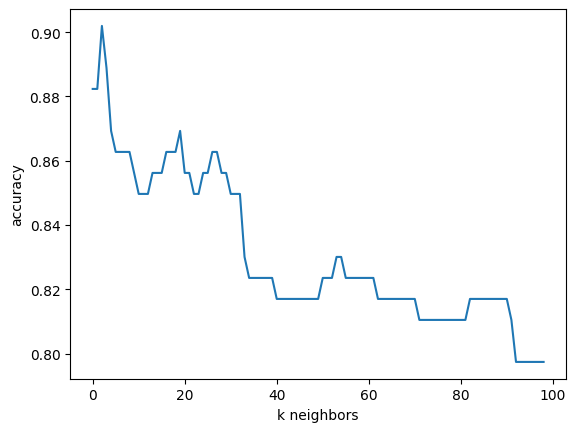

In [ ]:
test_accuracy = []

for k in tqdm(range(1, 100)):
    knn = kNN(n_neighbors=k, kernel='triangular', metric='manhattan')
    knn.fit(X_train.to_numpy(), Y_train.to_numpy())
    y_predicted = knn.predict(X_test.to_numpy())

    test_accuracy.append(accuracy_score(Y_test.to_numpy(), y_predicted))

plt.plot(test_accuracy, label='Test')
plt.xlabel("k neighbors")
plt.ylabel("accuracy")

plt.show()

## LOWESS сглаживание

In [14]:
knn = kNN(n_neighbors=4, kernel='triangular', metric='manhattan')
knn.fit(X_train.to_numpy(), Y_train.to_numpy())
y_pred = knn.predict(X_test.to_numpy())

y_lowess_pred = knn.lowess_predict(X_test.to_numpy())

print("Без взешиванием: ", accuracy_score(Y_test, y_pred))
print("Со взвешивания: ", accuracy_score(Y_test, y_lowess_pred))

100%|██████████| 611/611 [00:52<00:00, 11.60it/s]


Без взешиванием:  0.8888888888888888
Со взвешивания:  0.23529411764705882
